# Image classification using single layer neural network

In [1]:
%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
BATCH_SIZE = 64
N_EPOCHS = 100
WIDTH = 28
HEIGHT = 28
N_CLASSES = 10
LEARNING_RATE = 1e-3

In [6]:
dataset = MNIST(
    root="../data/", train=True, download=True, transform=transforms.ToTensor()
)

In [7]:
train_indices, val_indices = train_test_split(np.arange(0, len(dataset)))

In [8]:
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, BATCH_SIZE, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, BATCH_SIZE, sampler=val_sampler)

In [9]:
def accuracy(y_preds: torch.Tensor, y_true: torch.Tensor):
    return torch.sum(y_preds == y_true).item() / y_true.numel()

In [10]:
class MnistModel(nn.Module):
    def __init__(self, input_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.model = nn.Linear(input_size, num_classes)

    def forward(self, X):
        X = X.reshape(-1, self.input_size)
        return self.model(X)

    def predict(self, X):
        logits = self(X)
        loss = F.cross_entropy(logits,)

In [11]:
model = MnistModel(WIDTH * HEIGHT, N_CLASSES)

In [ ]:
optimiser = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
history = {
    "loss": [],
    "acc": [],
    "val_loss": [],
    "val_acc": [],    
}
for i in range(N_EPOCHS):
    _loss = []
    _acc = []
    _val_loss = []
    _val_acc = []
    _batch_sizes = []
    _val_batch_sizes = []
    
    # Training
    for b, (Xb, yb) in enumerate(train_loader):
        logits = model(Xb)
        loss = F.cross_entropy(logits, yb)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        # Metrics
        _loss.append(loss.detach().numpy())
        y_prob = F.softmax(logits, dim=1)
        y_pred_prob, y_preds = torch.max(y_prob, dim=1)
        acc = accuracy(y_preds, yb)
        _acc.append(acc)
        _batch_sizes.append(len(Xb))
    
    # Validation
    with torch.no_grad():
        for Xb, yb in val_loader:
            logits = model(Xb)
            val_loss = F.cross_entropy(logits, yb).detach().numpy()
            _val_loss.append(val_loss)
            y_prob = F.softmax(logits, dim=1)
            y_pred_prob, y_preds = torch.max(y_prob, dim=1)
            val_acc = accuracy(y_preds, yb)
            _val_acc.append(val_acc)
            _val_batch_sizes.append(len(Xb))
            
        
        # Weighted sum of losses to take into account non-equal batch sizes
        _loss = np.sum(np.multiply(_loss, _batch_sizes)) / np.sum(_batch_sizes)
        _val_loss = np.sum(np.multiply(_val_loss, _val_batch_sizes)) / np.sum(_val_batch_sizes)
        
        history["loss"].append(_loss)
        history["acc"].append(torch.Tensor(_acc).mean().item())
        history["val_acc"].append(torch.Tensor(_val_acc).mean().item())
        history["val_loss"].append(_val_loss)
        print(f"Epoch: {i + 1}/{N_EPOCHS}, acc: {history['acc'][-1]:.4f}, loss: {history['loss'][-1]:.4f}, val_acc: {history['val_acc'][-1]:.4f},  val_loss: {history['val_loss'][-1]:.4f}\r", end="")

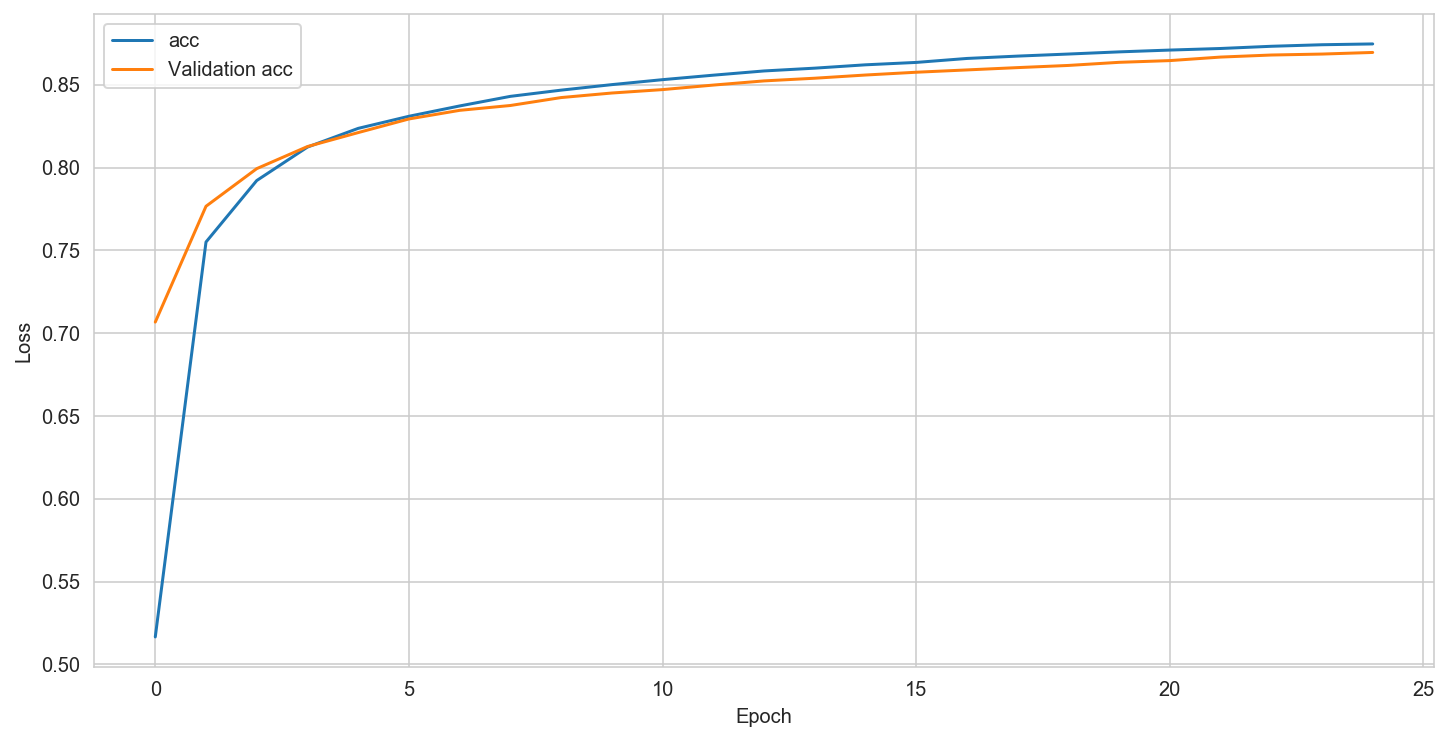

In [17]:
f, ax = plt.subplots(figsize=(12, 6))
metric = "acc"
sns.set_style("whitegrid")
ax.plot(
    np.arange(0, len(history[f"{metric}"])), history[f"{metric}"], label=f"{metric}"
)
ax.plot(
    np.arange(0, len(history[f"val_{metric}"])),
    history[f"val_{metric}"],
    label=f"Validation {metric}",
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.legend()

In [15]:
torch.save(model.state_dict(), "../models/mnist-logistic.pth")

In [16]:
loaded_model = MnistModel(WIDTH * HEIGHT, N_CLASSES)
loaded_model.load_state_dict(torch.load("../models/mnist-logistic.pth"))

<All keys matched successfully>